# Analysis for Thymus DNA-FISH

Data from: \\10.245.74.40\Turing3\Pu\Aire\20210729-Thymus_CTP10-Aire_DNA

by Pu Zheng

2020.04.30

In [2]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

21704


In [146]:
import numpy as np

In [149]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


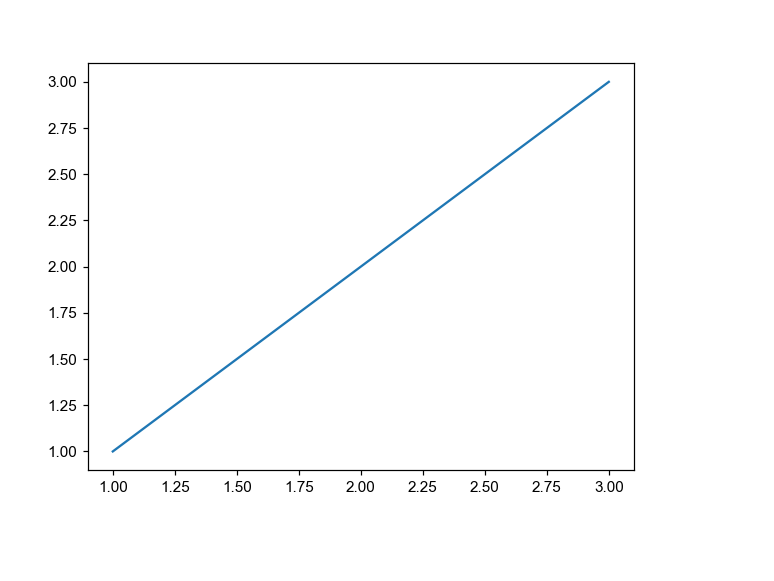

In [152]:
plt.figure()
plt.plot([1,2,3,], [1,2,3])

# 1. Create field-of-view class

In [3]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(get_img_info)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.40\Turing3\Pu\Aire\20210729-Thymus_CTP10-Aire_DNA',
             'save_folder':r'D:\Pu_Temp\20210729-Thymus_CTP10-Aire_DNA',
             'experiment_type': 'DNA',
             'num_threads': 13,
             #'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210514-Corrections_2color_50_new_fiber',
             'correction_folder':r'D:\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':True,
                     'corr_bleed':False,
                     'min_num_seeds':250,
                     'max_num_seeds': None,
                     'spot_seeding_th': 600,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':True
                 }, 
             'ref_id': 0, # special for this experiment
             }


In [4]:
# create fov class
_fov_id = 6
fov = classes.field_of_view.Field_of_View(fov_param, _fov_id=_fov_id,
                                          _color_info_kwargs={
                                              '_color_filename':'Color_Usage',
                                          }, 
                                          _prioritize_saved_attrs=False,
                                          )

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 26
- Number of field of views: 73
- Importing csv format color_usage file: \\10.245.74.40\Turing3\Pu\Aire\20210729-Thymus_CTP10-Aire_DNA\Analysis\Color_Usage.csv
- header: ['Hyb', '750', '647', '488', '405']
dict_keys(['H0C1', 'H1C2', 'H2C3', 'H3C4', 'H4C5', 'H5C6', 'H6C7', 'H7C8', 'H8C9', 'H9C10', 'H10C11', 'H11C12', 'H12C13', 'H13C14', 'H14C15', 'H15C16', 'H16C17', 'H17C18', 'H18C19', 'H19C20', 'H20C21', 'H21C22', 'H22C23', 'H23C24', 'H24C25', 'H25P1'])
- 26 folders are found according to color-usage annotation.
+ loading fov_info from file: D:\Pu_Temp\20210729-Thymus_CTP10-Aire_DNA\Conv_zscan_06.hdf5
++ base attributes loaded:['combo_ref_im', 'dapi_im', 'protein_ref_im'] in 4.211s.
+ loading correction from file: D:\Pu_Temp\20210729-Thymus_CTP10-Aire_DNA\Conv_zscan_06.hdf5
++ load chromatic correction profile directly from savefile.
++ load chromatic_constants correction profile directly from savefile.
++ load illu

In [5]:
# 3. load dapi image
dapi_im = fov._load_dapi_image(_dapi_id=0)

# 4. Process Protein images
fov.parallel = False
fov.protein_ref_id = 0
fov._process_image_to_spots('protein', 
                            _load_common_reference=True, _load_with_multiple=False,
                            _save_images=True,
                            _warp_images=True,
                            _fit_spots=False,
                            _overwrite_drift=False, _overwrite_image=False,
                            _overwrite_spot=False,
                            _verbose=True)

directly return existing attribute.
-- No folder selected, allow processing all 26 folders
used_channels: ['750', '647', '488', '405']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels: ['750', '647', '488']
used_channels:

In [5]:
# 2.0: create a seed mask from protein image Aire
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['protein']
    protein_ims = _grp['ims'][:]
    protein_ids = _grp['ids'][:]

<IPython.core.display.Javascript object>


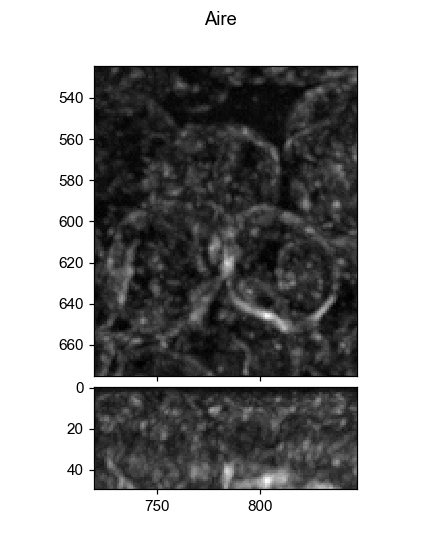

In [132]:
visual_tools.imshow_mark_3d_v2(protein_ims, image_names=['Aire'])

In [6]:
from scipy import ndimage
from skimage import exposure
from skimage import morphology

aire_im = protein_ims[0]
# Adaptive Equalization
#aire_adapteq_im = exposure.equalize_adapthist(aire_im, clip_limit=0.03)

def generate_analysis_mask(image, gaussian_size=6., snr_th=3):
    from scipy import ndimage
    # gaussian blur this image to ignore internal feature
    seg_im = ndimage.gaussian_filter(image.copy(), gaussian_size)
    seg_im = seg_im / io_tools.load.find_image_background(seg_im)
    mask = seg_im > snr_th
    return mask.astype(np.bool)

aire_mask = generate_analysis_mask(aire_im)

dialate_size = 3
dialated_mask = ndimage.binary_dilation(aire_mask, morphology.ball(dialate_size))

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


## visualize the mask

In [7]:
# 2.0: create a seed mask from combo image Aire
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_ims = _grp['ims'][:]
    combo_ids = _grp['ids'][:]

<IPython.core.display.Javascript object>


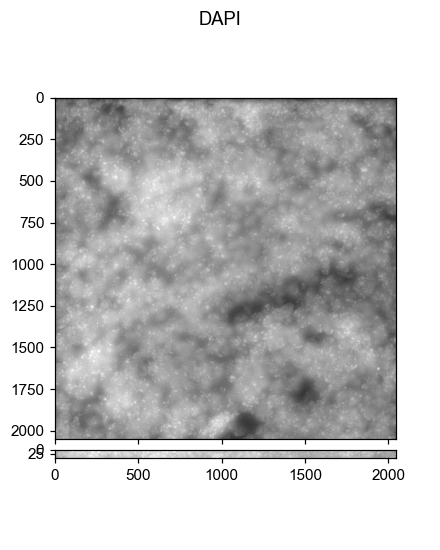

In [23]:
visual_tools.imshow_mark_3d_v2([fov.dapi_im], image_names=['DAPI'])

<IPython.core.display.Javascript object>


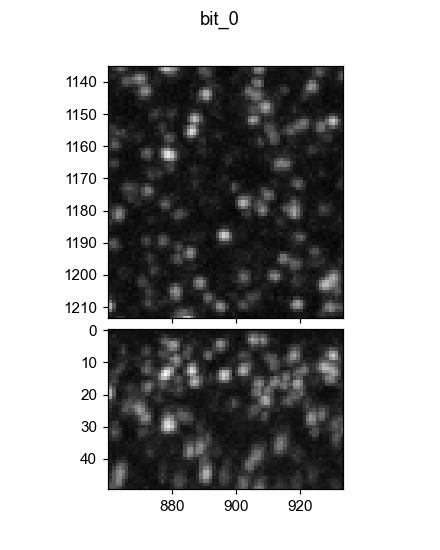

In [22]:
visual_tools.imshow_mark_3d_v2(combo_ims, image_names=[f"bit_{_i}" for _i in range(len(combo_ims))])

<IPython.core.display.Javascript object>


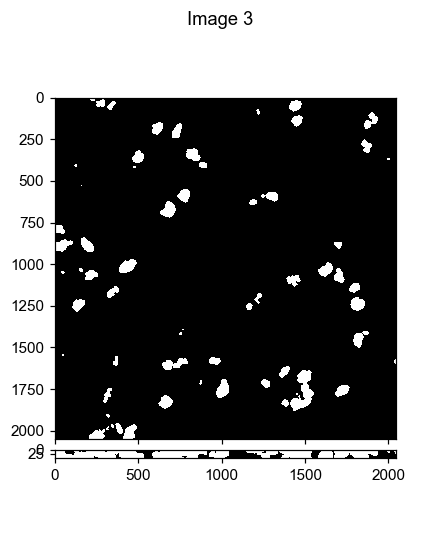

In [14]:
visual_tools.imshow_mark_3d_v2([aire_im, aire_mask, dialated_mask])

In [132]:
with h5py.File(fov.save_filename, "a", libver='latest') as _f:
    _grp = _f['combo']
    #_spot_dataset = _grp['spots']
    print(_grp.keys())
    if 'spots' not in _grp.keys():
        _grp.create_dataset('spots',
                        (_grp['ids'].shape[0], 500, 11), 
                        dtype='f', maxshape=(_grp['ids'].shape[0], None, 11), chunks=True)
        _grp.create_dataset('raw_spots',
                        (_grp['ids'].shape[0], 500, 11), 
                        dtype='f', maxshape=(_grp['ids'].shape[0], None, 11), chunks=True)

<KeysViewHDF5 ['channels', 'drifts', 'flags', 'ids', 'ims']>


In [133]:
_overwrite_image = False
_overwrite_spot = False
# 2. Process image into candidate spots
fov.parallel=False
fov.combo_ref_id = 0
fov._process_image_to_spots('combo', 
                            _load_common_reference=True, _load_with_multiple=False,
                            _save_images=True,
                            _warp_images=False, 
                            _fit_spots=True,
                            _fit_in_mask=True,
                            _fitting_args={'seed_mask':dialated_mask},
                            _overwrite_drift=False, _overwrite_image=_overwrite_image,
                            _overwrite_spot=_overwrite_spot,
                            _verbose=True)

-- No folder selected, allow processing all 26 folders
-- checking combo, region:[1 2] in 0.007s.
used_channels: ['750', '647', '488', '405']
-- checking combo, region:[3 4] in 0.005s.
used_channels: ['750', '647', '488']
-- checking combo, region:[5 6] in 0.005s.
used_channels: ['750', '647', '488']
-- checking combo, region:[7 8] in 0.004s.
used_channels: ['750', '647', '488']
-- checking combo, region:[ 9 10] in 0.005s.
used_channels: ['750', '647', '488']
-- checking combo, region:[11 12] in 0.003s.
used_channels: ['750', '647', '488']
-- checking combo, region:[13 14] in 0.000s.
used_channels: ['750', '647', '488']
-- checking combo, region:[15 16] in 0.000s.
used_channels: ['750', '647', '488']
-- checking combo, region:[17 18] in 0.019s.
used_channels: ['750', '647', '488']
-- checking combo, region:[19 20] in 0.004s.
used_channels: ['750', '647', '488']
-- checking combo, region:[21 22] in 0.004s.
used_channels: ['750', '647', '488']
-- checking combo, region:[23 24] in 0.004s.

E:\Users\puzheng\anaconda3\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


1509 fitted in 110.736s.
-- start fitting spots in channel:647, 166080 seeded, 4142 selected by mask, 4140 fitted in 403.228s.
- writting combo spots into file:D:\Pu_Temp\20210729-Thymus_CTP10-Aire_DNA\Conv_zscan_03.hdf5
-- resize combo_spots and combo_raw_spots from 500 to 1509.
0
-- resize combo_spots and combo_raw_spots from 1509 to 4140.
1
-- updated spots for id:[1, 2] in 0.031s
+ batch process image: \\10.245.74.40\Turing3\Pu\Aire\20210729-Thymus_CTP10-Aire_DNA\H1C2\Conv_zscan_03.dax for channels:['750', '647']
- loading combo info from file:Conv_zscan_03.hdf5 in 2.828s.
- writting combo info to file:D:\Pu_Temp\20210729-Thymus_CTP10-Aire_DNA\Conv_zscan_03.hdf5
-- images and drifts already exist, skip.
-- no updates in drift, skip.
-- start traslating seed_mask by drift: [-0.09  8.58  1.45] -- in 85.39s.
-- start fitting spots in channel:750, 67582 seeded, 738 selected by mask, 738 fitted in 82.094s.
-- start fitting spots in channel:647, 162381 seeded, 1963 selected by mask, 1963

KeyboardInterrupt: 

In [20]:
fov._load_from_file('combo', _overwrite=True)

+ loading combo from file: D:\Pu_Temp\20210729-Thymus_CTP10-Aire_DNA\Conv_zscan_06.hdf5
++ finish loading combo in 0.077s. 


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1628: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


In [21]:
for _spots in fov.combo_spots_list:
    print(len(_spots))

575
2146
528
1706
598
1611
583
1443
550
1625
689
1792
420
1767
853
1916
728
1580
560
1608
655
2016
577
1652
655
1549
645
1995
579
1685
926
1105
998
1064
757
1499
590
1238
929
1571
664
1179
673
1002
602
1769
455
1215
708
1956


In [14]:
# load codebook
import pandas as pd
codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-10_Aire\Summary_tables\CTP10-Aire_codebook.csv').set_index('id')
codebook

name  NDB_784  NDB_755  NDB_826  NDB_713  NDB_865  NDB_725  NDB_817  \
id                                                                           
0    Ccl21a        0        0        0        0        0        0        0   
1     Krt14        0        0        0        0        0        0        0   
2      Krt5        0        0        0        0        0        0        0   
3    Col6a1        0        0        1        0        0        0        0   
4      Lifr        0        0        1        0        0        0        0   
..      ...      ...      ...      ...      ...      ...      ...      ...   
204     Ltf        1        0        0        0        0        0        0   
205    Clps        0        0        0        0        0        0        1   
206  Col1a1        0        0        0        0        0        0        0   
207    Gpx6        0        0        0        0        1        0        0   
208   Plvap        0        0        0        0        0        0        0   

     NDB_710  NDB_652  ...  NDB_883  NDB_863  NDB_1033  NDB_878  NDB_631  \
id                     ...                                                 
0          1        0  ...        0        0         0        0        0   
1          0        0  ...        0        0         0        0        0   
2          0        0  ...        0        0         0        0        0   
3          0        0  ...        0        1         0        0        0   
4          0        0  ...        0        0         0        0        0   
..       ...      ...  ...      ...      ...       ...      ...      ...   
204        0        0  ...        0        0         0        0        0   
205        0        0  ...        0        0         0        0        0   
206        0        0  ...        0        0         0        1        0   
207        0        0  ...        1        0         0        0        0   
208        0        0  ...        0        1         0        0        0   

     NDB_758  NDB_1075  NDB_653  chr  chr_order  
id                                               
0          0         0        0    4          3  
1          1         0        0   11         23  
2          0         0        0   15          9  
3          0         0        0   10          1  
4          0         0        0   15          0  
..       ...       ...      ...  ...        ...  
204        0         0        0    9         14  
205        1         0        0   17          1  
206        0         0        0   11         17  
207        0         0        0   13          1  
208        0         0        0    8          1  

[209 rows x 53 columns]

In [16]:
codebook[codebook.columns[1:-2]].sum(1), codebook[codebook.columns[1:-2]].sum(0)

(id
 0      3
 1      3
 2      3
 3      3
 4      3
       ..
 204    3
 205    3
 206    3
 207    3
 208    3
 Length: 209, dtype: int64, NDB_784     13
 NDB_755     12
 NDB_826     13
 NDB_713     12
 NDB_865     13
 NDB_725     13
 NDB_817     13
 NDB_710     12
 NDB_652     12
 NDB_971     13
 NDB_718     13
 NDB_743     12
 NDB_847     13
 NDB_683     13
 NDB_643     13
 NDB_815     12
 NDB_760     12
 NDB_965     13
 NDB_790     12
 NDB_917     13
 NDB_778     13
 NDB_728     13
 NDB_844     12
 NDB_974     12
 NDB_961     12
 NDB_746     12
 NDB_661     12
 NDB_875     12
 NDB_901     12
 NDB_773     13
 NDB_868     12
 NDB_812     12
 NDB_1027    13
 NDB_716     12
 NDB_754     13
 NDB_860     13
 NDB_856     13
 NDB_680     13
 NDB_634     13
 NDB_737     13
 NDB_715     13
 NDB_698     12
 NDB_883     12
 NDB_863     13
 NDB_1033    12
 NDB_878     13
 NDB_631     12
 NDB_758     13
 NDB_1075    12
 NDB_653     13
 dtype: int64)

In [17]:
# load codebook
import pandas as pd
codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-10_Aire\Summary_tables\CTP10-Aire_codebook.csv').set_index('id')


codebook.loc[codebook['chr']=='X', 'chr'] = '20'
codebook['chr'] = codebook['chr'].astype(np.int32)

codebook

name  NDB_784  NDB_755  NDB_826  NDB_713  NDB_865  NDB_725  NDB_817  \
id                                                                           
0    Ccl21a        0        0        0        0        0        0        0   
1     Krt14        0        0        0        0        0        0        0   
2      Krt5        0        0        0        0        0        0        0   
3    Col6a1        0        0        1        0        0        0        0   
4      Lifr        0        0        1        0        0        0        0   
..      ...      ...      ...      ...      ...      ...      ...      ...   
204     Ltf        1        0        0        0        0        0        0   
205    Clps        0        0        0        0        0        0        1   
206  Col1a1        0        0        0        0        0        0        0   
207    Gpx6        0        0        0        0        1        0        0   
208   Plvap        0        0        0        0        0        0        0   

     NDB_710  NDB_652  ...  NDB_883  NDB_863  NDB_1033  NDB_878  NDB_631  \
id                     ...                                                 
0          1        0  ...        0        0         0        0        0   
1          0        0  ...        0        0         0        0        0   
2          0        0  ...        0        0         0        0        0   
3          0        0  ...        0        1         0        0        0   
4          0        0  ...        0        0         0        0        0   
..       ...      ...  ...      ...      ...       ...      ...      ...   
204        0        0  ...        0        0         0        0        0   
205        0        0  ...        0        0         0        0        0   
206        0        0  ...        0        0         0        1        0   
207        0        0  ...        1        0         0        0        0   
208        0        0  ...        0        1         0        0        0   

     NDB_758  NDB_1075  NDB_653  chr  chr_order  
id                                               
0          0         0        0    4          3  
1          1         0        0   11         23  
2          0         0        0   15          9  
3          0         0        0   10          1  
4          0         0        0   15          0  
..       ...       ...      ...  ...        ...  
204        0         0        0    9         14  
205        1         0        0   17          1  
206        0         0        0   11         17  
207        0         0        0   13          1  
208        0         0        0    8          1  

[209 rows x 53 columns]

In [19]:
from scipy.spatial.distance import cdist
from itertools import combinations
from tqdm import tqdm
dist_th=200

decoded_dict = {}

for _index in tqdm(codebook.index):
    _gene = codebook['name'][_index]
    _code = np.array(codebook.loc[_index, codebook.columns[1:-2]], dtype=np.int32)
    #print('*', _gene, len(_code))
    # for this code calculate pairwise distance
    sel_hzxys_list = []
    sel_spots_list = []
    onbits = np.where(_code)[0]
    for _onbit in onbits:

        _hzxys = fov.combo_spots_list[_onbit][:,:4].copy()
        _hzxys[:,1:4] = _hzxys[:,1:4] * fov.shared_parameters['distance_zxy']
        #print(_onbit, len(_hzxys))
        sel_hzxys_list.append(_hzxys)
        sel_spots_list.append(fov.combo_spots_list[_onbit])

    # calculate all pairwise distance
    distance_dict = {}
    for _cb in combinations(list(onbits),2):
        #print(_cb)
        distance_dict[_cb] = cdist(fov.combo_spots_list[_cb[0]][:,1:4]*fov.shared_parameters['distance_zxy'], 
                                   fov.combo_spots_list[_cb[1]][:,1:4]*fov.shared_parameters['distance_zxy'],)

    # find pairs within threshold
    sel_pairs_dict = {}
    for _cb, _dists in distance_dict.items():
        sel_pairs_dict[_cb] = np.where(_dists < dist_th)
        #print(len(sel_pairs_dict[_cb][0]))

    onbit_table = {}
    sel_spot_df = pd.DataFrame(columns=list(onbits), index=[], dtype=np.int32)
    for _cb, _pairs in sel_pairs_dict.items():
        for _l,_r in zip(_pairs[0], _pairs[1]):
            if _l in np.array(sel_spot_df[_cb[0]]) and _r in np.array(sel_spot_df[_cb[1]]):
                #print(sel_spot_df.loc[sel_spot_df[_cb[0]]==_l],_l,_r)
                #print(_l,_r)
                _l_loc = (sel_spot_df[_cb[0]]==_l)
                _r_loc = (sel_spot_df[_cb[1]]==_r)
                if (_l_loc == _r_loc).all():
                    pass
                else:
                    #print('mixed pairs')
                    pass
            elif _l in np.array(sel_spot_df[_cb[0]]) or _r in np.array(sel_spot_df[_cb[1]]):
                #print('*',_l,_r, _cb)
                #print(sel_spot_df[list(_cb)])
                if _l in np.array(sel_spot_df[_cb[0]]):
                    #print('left')
                    _loc = (sel_spot_df[_cb[0]]==_l)
                    sel_spot_df.loc[_loc,_cb[1]] = _r
                else:
                    #print('right')
                    _loc = (sel_spot_df[_cb[1]]==_r)
                    sel_spot_df.loc[_loc,_cb[0]] = _l

            else:
                sel_spot_df=sel_spot_df.append({_cb[0]:_l, _cb[1]:_r}, ignore_index=True)

    # append intensity
    for _onbit in onbits:
        _int_list = []
        for _id in sel_spot_df[_onbit]:
            if np.isnan(_id):
                _int_list.append(np.nan)
            else:
                _int_list.append(fov.combo_spots_list[_onbit][int(_id), 0])

        sel_spot_df[f"{_onbit}_int"] = _int_list
    # append mean coordinates
    mean_coord_list = []
    for _onbit in onbits:
        _coord_list = []
        for _id in sel_spot_df[_onbit]:
            if np.isnan(_id):
                _coord_list.append(np.ones(3)*np.nan)
            else:
                _coord_list.append(fov.combo_spots_list[_onbit][int(_id), 1:4])
        mean_coord_list.append(_coord_list)
    mean_coord_list = np.nanmean(mean_coord_list, axis=0)
    sel_spot_df[['mean_z', 'mean_x', 'mean_y']] = mean_coord_list
    
    # append
    decoded_dict[_gene] = sel_spot_df

  0%|                                                                                          | 0/209 [00:00<?, ?it/s]


AttributeError: 'Field_of_View' object has no attribute 'combo_spots_list'

<IPython.core.display.Javascript object>


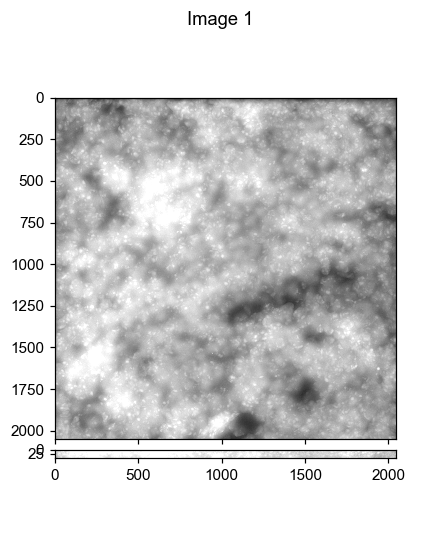

In [225]:
visual_tools.imshow_mark_3d_v2([fov.dapi_im])

<IPython.core.display.Javascript object>


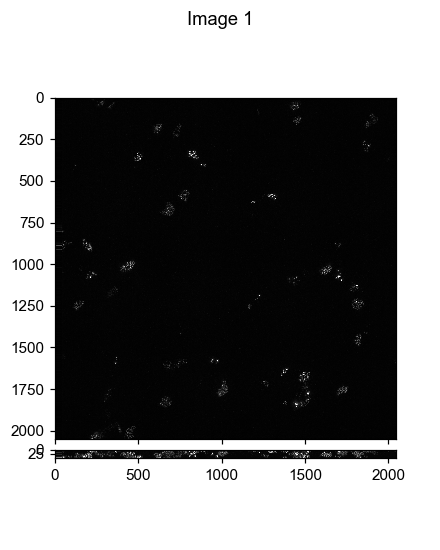

In [224]:
visual_tools.imshow_mark_3d_v2(protein_ims)

In [220]:
codebook.loc[codebook['name']==_gene]['chr']x

id
208    8
Name: chr, dtype: int32

array([  -1,    0,    1, ..., 1193, 1194, 1195], dtype=int64)

In [237]:
plt.figure()
plt.

array([[  15.08388472,  684.3236084 ,  704.68276978],
       [  13.34817378, 1743.94010417, 1016.40266927],
       [  15.50625277, 1704.65606689, 1002.55725098],
       ...,
       [  25.48192596, 1812.90814209, 1502.90588379],
       [  32.46941185,   40.93743134, 1445.13720703],
       [  10.41748953, 1086.75799561,  188.59345245]])

In [227]:
_sel_spot_df[_sel_spot_df.columns[:3]]

31      33     43
0      2.0    11.0    NaN
1     15.0     9.0    NaN
2     77.0    19.0   27.0
3     83.0     7.0    4.0
4     97.0   173.0    NaN
5    103.0    68.0   24.0
6    124.0    65.0  105.0
7    177.0   295.0  433.0
8    199.0    53.0    NaN
9    218.0   391.0  269.0
10   233.0   277.0    NaN
11   240.0   189.0    NaN
12   296.0   573.0    NaN
13   518.0   438.0    NaN
14   605.0   249.0  323.0
15   808.0   512.0    NaN
16   916.0  1058.0    NaN
17   959.0   886.0    NaN
18     0.0     NaN    3.0
19    44.0     NaN  951.0
20    57.0     NaN  450.0
21    90.0   141.0  243.0
22    98.0     NaN   11.0
23   111.0    45.0   40.0
24   117.0     NaN  208.0
25   120.0     NaN  122.0
26   169.0     NaN  490.0
27   191.0     NaN   50.0
28   195.0     NaN  334.0
29   230.0     NaN   91.0
30   241.0     NaN  251.0
31   249.0     NaN  120.0
32   407.0     NaN  522.0
33   634.0   394.0  862.0
34   698.0     NaN  819.0
35   714.0     NaN  767.0
36   834.0     NaN  759.0
37   994.0     NaN  642.0
38  1074.0     NaN  899.0
39     NaN    37.0  227.0
40     NaN    64.0   42.0
41     NaN    79.0   98.0
42     NaN   148.0  116.0
43     NaN   185.0  548.0
44     NaN   196.0  240.0
45     NaN   210.0  376.0
46     NaN   341.0  213.0
47     NaN   362.0  608.0
48     NaN   447.0  360.0
49     NaN   471.0  276.0
50     NaN   722.0  887.0
51     NaN   723.0  133.0

In [ ]:
for _gene, _sel_spot_df in tqdm(decoded_dict.items()):
    _sel_spot_df[_sel_spot_df.columns[:3]]

In [221]:
_coords = []
_class_ids = []
_chr_names = []
for _gene, _sel_spot_df in tqdm(decoded_dict.items()):
    #print(_gene, len(_sel_spot_df))
    _coords.append(_sel_spot_df[['mean_z','mean_x','mean_y']])
    _class_ids.append(codebook.loc[codebook['name']==_gene].index[0] * np.ones(len(_sel_spot_df),dtype=np.int32))
    _chr_names.append(int(codebook.loc[codebook['name']==_gene,'chr']) * np.ones(len(_sel_spot_df),dtype=np.int32))
_coords = np.concatenate(_coords)
_class_ids = np.concatenate(_class_ids)
_chr_names = np.concatenate(_chr_names)

100%|████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 615.26it/s]


<IPython.core.display.Javascript object>


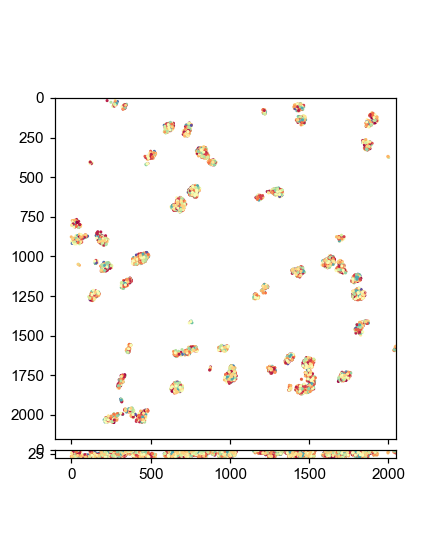

In [222]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(4,5))
ax1,ax2 = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.1)
ax1.imshow(aire_im.max(0), cmap='gray_r', vmin=1000, vmax=30000)
ax1.scatter(_coords[:,2], _coords[:,1],cmap=Spectral, vmin=1, vmax=20,
        c=_chr_names, s=1)
ax2.imshow(aire_im.max(1), cmap='gray_r', vmin=1000, vmax=30000)
ax2.scatter(_coords[:,2], _coords[:,0],cmap=Spectral, vmin=1, vmax=20,
        c=_chr_names, s=1)

<IPython.core.display.Javascript object>


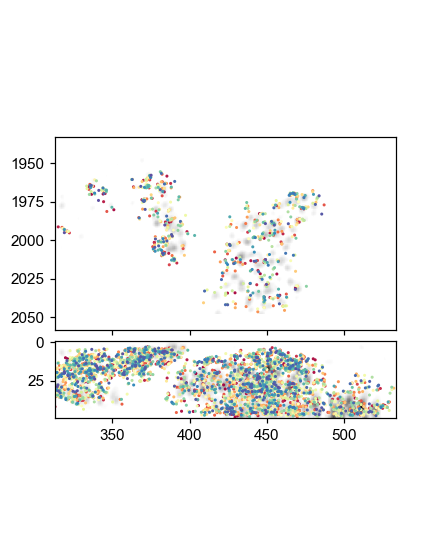

In [153]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(4,5))
ax1,ax2 = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.1)
ax1.imshow(aire_im.max(0), cmap='gray_r', vmin=1000, vmax=30000)
ax1.scatter(_coords[:,2], _coords[:,1],cmap=Spectral, 
        c=_class_ids, s=1)
ax2.imshow(aire_im.max(1), cmap='gray_r', vmin=1000, vmax=30000)
ax2.scatter(_coords[:,2], _coords[:,0],cmap=Spectral, 
        c=_class_ids, s=1)

In [32]:
all_spots = np.concatenate(fov.combo_spots_list)
all_class_ids = np.concatenate([np.ones(len(_spots), dtype=np.int32)*_i for _i, _spots in enumerate(fov.combo_spots_list)])

all_coords = np.concatenate([_spots[:,1:4]*fov.shared_parameters['distance_zxy'] for _spots in fov.combo_spots_list])


In [86]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=300, min_samples=2, n_jobs=32).fit(all_coords)
labels = model.labels_

In [87]:
codebook_mat = np.array(codebook[codebook.columns[1:-2]])

In [121]:
clusters, num_spots = np.unique(model.labels_, return_counts=True)

kept_decoded_genes =  {}
decoded_on_bits = []

for _cluster_id, _n in zip(clusters, num_spots):
    
    if _n >= 2 and _n <= 4:
        _cluster_onbits = all_class_ids[labels==_cluster_id]
        _code = np.zeros(50, dtype=np.int32)
        _code[_cluster_onbits] = 1
        _hamming_dists = np.abs(codebook_mat - _code).sum(1)
        if (_hamming_dists <= 2).any():
            #print(_cluster_id, _n, np.where(_hamming_dists < 2)[0][0])
            if len(np.where(_hamming_dists <= 2)[0]) > 1:
                continue
                
            kept_decoded_genes[_cluster_id] = np.where(_hamming_dists <= 2)[0][0]
            
            decoded_on_bits.append(_n)
        
        

In [126]:
kept_decoded_zxys = []
kept_gene_ids = []
for _cluster_id, _gene in kept_decoded_genes.items():
    _spots = all_spots[np.where(labels==_cluster_id)]
    _mean_zxy = np.mean(_spots, axis=0)[1:4]
    kept_decoded_zxys.append(_mean_zxy)
    kept_gene_ids.append(_gene)
kept_decoded_zxys = np.array(kept_decoded_zxys)
kept_gene_ids = np.array(kept_gene_ids)

<IPython.core.display.Javascript object>


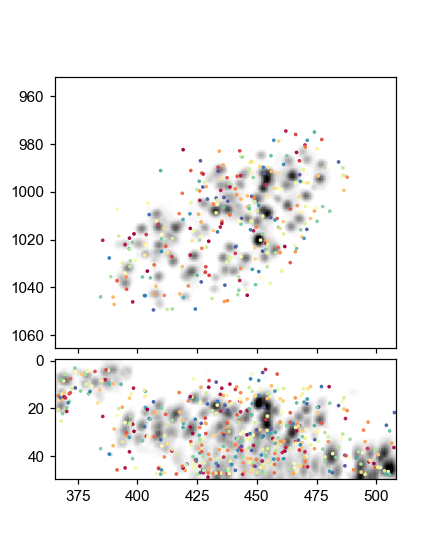

In [136]:
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.cm import Reds, Blues, Spectral
kept_inds = model.labels_ >= 0

fig = plt.figure(figsize=(4,5))
ax1,ax2 = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.1)
ax1.imshow(aire_im.max(0), cmap='gray_r', vmin=1000, vmax=20000)
ax1.scatter(kept_decoded_zxys[:,2], kept_decoded_zxys[:,1],cmap=Spectral, 
        c=kept_gene_ids, s=2)
ax2.imshow(aire_im.max(1), cmap='gray_r', vmin=1000, vmax=20000)
ax2.scatter(kept_decoded_zxys[:,2], kept_decoded_zxys[:,0], cmap=Spectral, 
        c=kept_gene_ids, s=2)

In [137]:
np.sum((kept_decoded_zxys[:,2] > 375) * (kept_decoded_zxys[:,2] < 500) \
       * (kept_decoded_zxys[:,1] > 960) * (kept_decoded_zxys[:,1] < 1060))

258

In [142]:
kept_gene_ids

array([171, 149,  17, ...,   9,   9,   9], dtype=int64)

In [140]:
kept_inds = (kept_decoded_zxys[:,2] > 375) * (kept_decoded_zxys[:,2] < 500) \
       * (kept_decoded_zxys[:,1] > 960) * (kept_decoded_zxys[:,1] < 1060)

In [145]:
np.unique(kept_gene_ids[kept_inds]).shape

(139,)

In [120]:
3/(3988/1048+3)

0.4408300616937746

In [117]:
ax.hist(decoded_on_bits, bins=np.arange(2,6), density=False, width=0.5 )

(array([3988., 1048.,  292.]),
 array([2, 3, 4, 5]),
 <BarContainer object of 3 artists>)

<IPython.core.display.Javascript object>


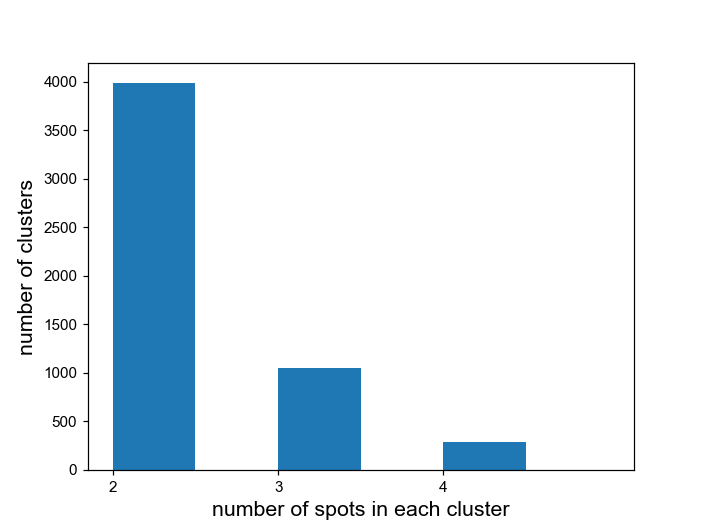

In [116]:
fig, ax = plt.subplots()
ax.hist(decoded_on_bits, bins=np.arange(2,6), density=False, width=0.5 )
ax.set_xticks([2,3,4])

ax.set_xlabel(f"number of spots in each cluster", fontsize=14)
ax.set_ylabel(f"number of clusters", fontsize=14)
plt.show()

In [108]:
0.83663551 / 0.11588785

7.21935483314256

<IPython.core.display.Javascript object>


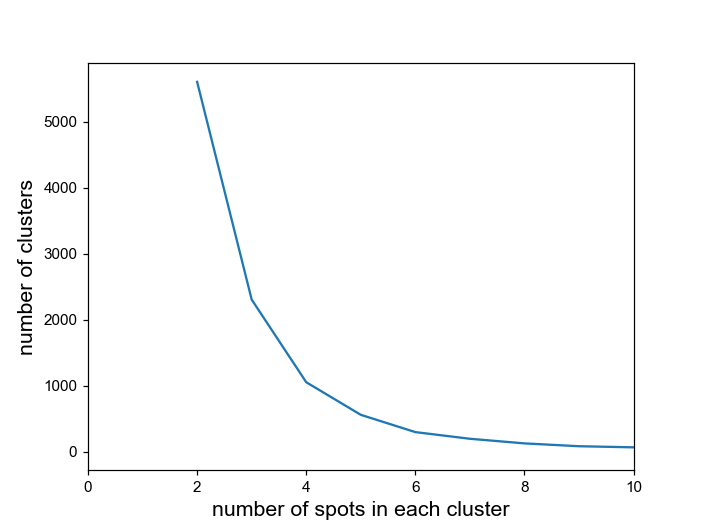

In [99]:
_x, _y = np.unique(np.unique(model.labels_, return_counts=True)[1], return_counts=True)
plt.figure()
plt.plot(_x,_y)
plt.xlabel(f"number of spots in each cluster", fontsize=14)
plt.ylabel(f"number of clusters", fontsize=14)

plt.xlim(0,10)
plt.show()

<IPython.core.display.Javascript object>


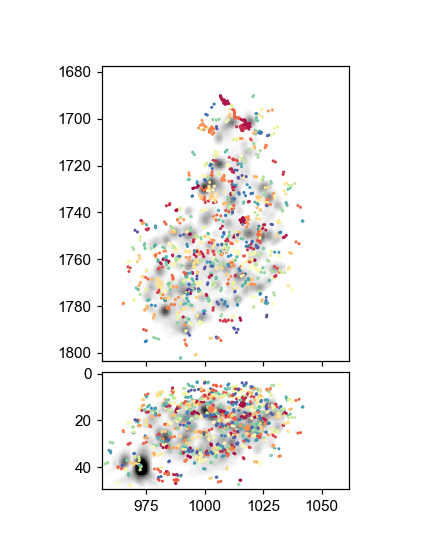

In [41]:
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.cm import Reds, Blues, Spectral
kept_inds = model.labels_ >= 0

fig = plt.figure(figsize=(4,5))
ax1,ax2 = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.1)
ax1.imshow(aire_im.max(0), cmap='gray_r', vmin=1000, vmax=20000)
ax1.scatter(all_spots[kept_inds,3], all_spots[kept_inds,2],cmap=Spectral, 
        c=model.labels_[kept_inds], s=1)
ax2.imshow(aire_im.max(1), cmap='gray_r', vmin=1000, vmax=20000)
ax2.scatter(all_spots[kept_inds,3], all_spots[kept_inds,1], cmap=Spectral, 
        c=model.labels_[kept_inds], s=1)

100%|███████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 2236.13it/s]


<IPython.core.display.Javascript object>


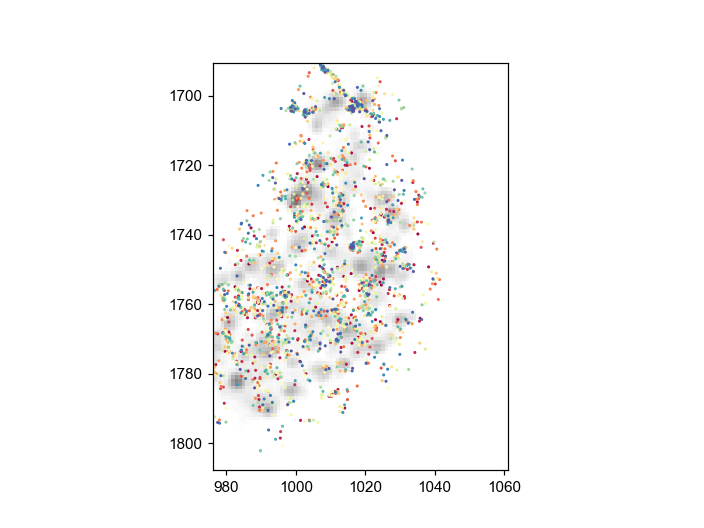

In [146]:
# extract all coordinates

_coords1 = []
_coords2 = []
_class_ids = []

for _gene, _sel_spot_df in tqdm(decoded_dict.items()):
    #print(_gene, len(_sel_spot_df))
    _coords1.append(_sel_spot_df['mean_x'])
    _coords2.append(_sel_spot_df['mean_y'])
    _class_ids.append(codebook.loc[codebook['name']==_gene].index[0] * np.ones(len(_sel_spot_df),dtype=np.int32))
_coords1 = np.concatenate(_coords1)
_coords2 = np.concatenate(_coords2)
_class_ids = np.concatenate(_class_ids)

from matplotlib.cm import Reds, Blues, Spectral
fig, ax = plt.subplots()
ax.imshow(aire_mask.max(0), cmap='Blues', vmin=0, vmax=5)
ax.imshow(aire_im.max(0), cmap='gray_r', vmin=1000, vmax=30000)
ax.scatter(_coords2, _coords1,cmap=Spectral, 
        c=_class_ids, s=1)

ax.set_aspect('equal')
plt.show()

In [74]:
fov._load_from_file('combo', _overwrite=True)

+ loading combo from file: D:\Pu_Temp\20210729-Thymus_CTP10-Aire_DNA\Conv_zscan_06.hdf5
++ finish loading combo in 0.051s. 


E:\Users\puzheng\Documents\ImageAnalysis3\classes\field_of_view.py:1631: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _spots_list = np.array([_spots[_spots[:,0] > 0] for _flg, _spots in zip(_flags, _grp['spots'][:]) if _flg > 0])


In [121]:
# for this code calculate pairwise distance
sel_hzxys_list = []
sel_spots_list = []
for _onbit in np.where(_code)[0]:
    
    _hzxys = fov.combo_spots_list[_onbit][:,:4].copy()
    _hzxys[:,1:4] = _hzxys[:,1:4] * fov.shared_parameters['distance_zxy']
    print(_onbit, len(_hzxys))
    sel_hzxys_list.append(_hzxys)
    sel_spots_list.append(fov.combo_spots_list[_onbit])

7 1443
26 645
35 1499


In [93]:
from itertools import combinations
# calculate all pairwise distance
distance_dict = {}
for _cb in combinations(range(len(sel_hzxys_list)),2):
    print(_cb)
    distance_dict[_cb] = cdist(sel_hzxys_list[_cb[0]][:,1:4], sel_hzxys_list[_cb[1]][:,1:4])

(0, 1)
(0, 2)
(1, 2)


In [135]:
dist_th=300
sel_pairs_dict = {}
for _cb, _dists in distance_dict.items():
    sel_pairs_dict[_cb] = np.where(_dists < dist_th)
    print(len(sel_pairs_dict[_cb][0]))

12
50
9


In [136]:
from matplotlib.cm import Reds, Blues, Spectral

In [137]:
Reds(1/3)

(0.9882352941176471, 0.6261437908496732, 0.5084967320261438, 1.0)

<IPython.core.display.Javascript object>


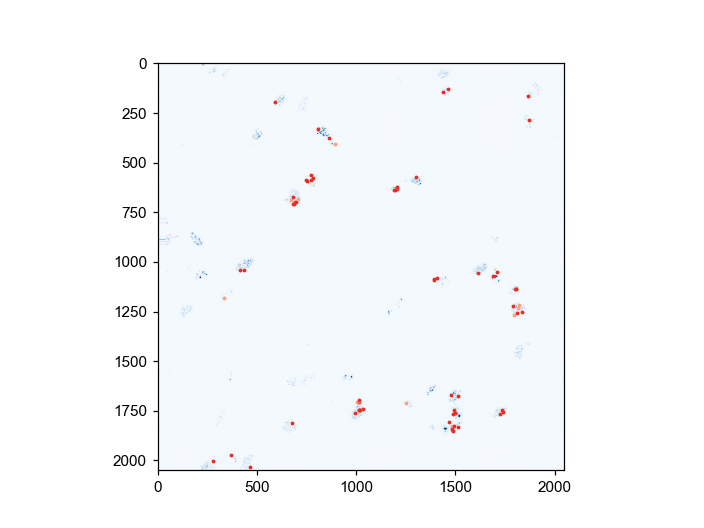

In [140]:
fig, ax = plt.subplots()
#ax.imshow(aire_mask.max(0), cmap='Blues', vmin=0, vmax=5)
ax.imshow(aire_im.max(0), cmap='Blues', vmin=0, vmax=20000)
for _cb, _pairs in sel_pairs_dict.items():
    _left_spots = sel_spots_list[_cb[0]][_pairs[0]]
    _right_spots = sel_spots_list[_cb[1]][_pairs[1]]

    ax.plot(_left_spots[:,3], _left_spots[:,2], '.', 
            c=Reds(_cb[0]/len(sel_hzxys_list)), markersize=3)
    ax.plot(_right_spots[:,3], _right_spots[:,2], '.', 
            c=Reds(_cb[1]/len(sel_hzxys_list)), markersize=3)

ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


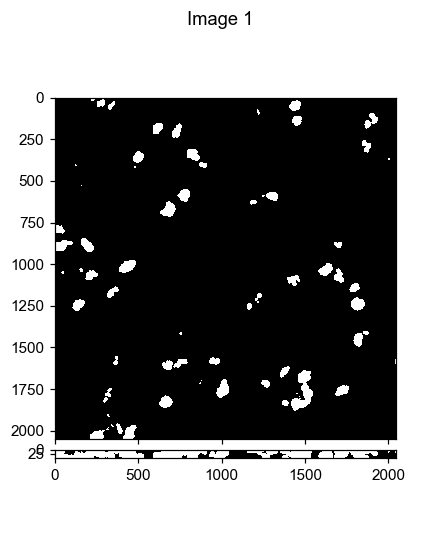

In [85]:
visual_tools.imshow_mark_3d_v2([aire_mask])

In [84]:
np.where(distances < 250)

(array([ 214,  521,  567, 1349], dtype=int64),
 array([ 47, 324, 469, 481], dtype=int64))

In [27]:
fov.shared_parameters['distance_zxy']

[250, 108, 108]

<IPython.core.display.Javascript object>


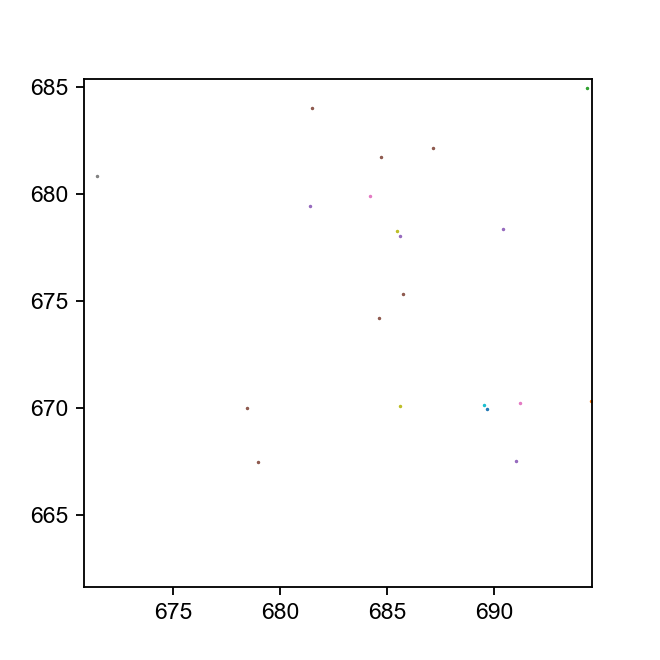

In [24]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
for _id, _spots in zip(fov.combo_ids, fov.combo_spots_list):
    if len(_spots) > 0:
        _sel_spots = _spots[(_spots[:,1] > 33) * (_spots[:,1] <= 35)]
        
        ax.plot(_sel_spots[:,2], _sel_spots[:,3], '.', markersize=1, )

ax.set_aspect('equal', 'box')
plt.show()


In [22]:
with h5py.File(fov.save_filename, "a", libver='latest') as _f:
    _grp = _f['combo']
    del(_grp['combo_ref_im'])

In [48]:
with h5py.File(fov.save_filename, "a", libver='latest') as _f:
    _grp = _f['combo']
    _spot_dataset = _grp['spots']
    print(_spot_dataset.shape, _spot_dataset.maxshape)

(50, 500, 11) (50, None, 11)


In [19]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_ims = _grp['ims'][:]
    combo_ids = _grp['ids'][:]

<IPython.core.display.Javascript object>


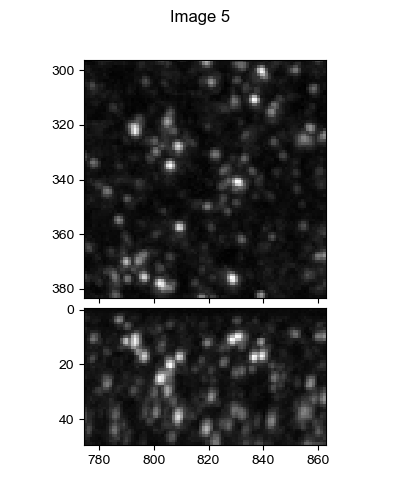

In [54]:
%matplotlib notebook
visual_tools.imshow_mark_3d_v2([protein_ims[0]]+list(combo_ims))


In [55]:
from skimage import exposure

aire_im = protein_ims[0]
# Adaptive Equalization
#aire_adapteq_im = exposure.equalize_adapthist(aire_im, clip_limit=0.03)

In [56]:
def generate_analysis_mask(image, gaussian_size=6., snr_th=3):
    from scipy import ndimage
    # gaussian blur this image to ignore internal feature
    seg_im = ndimage.gaussian_filter(image.copy(), gaussian_size)
    seg_im = seg_im / io_tools.load.find_image_background(seg_im)
    mask = seg_im > snr_th
    return mask.astype(np.bool)

aire_mask = generate_analysis_mask(aire_im)

In [79]:
image = combo_ims[0].copy()
seeds = spot_tools.fitting.get_seeds(image, max_num_seeds=None, th_seed=600, return_h=True)

In [141]:
reload(spot_tools.fitting)

<module 'ImageAnalysis3.spot_tools.fitting' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\spot_tools\\fitting.py'>

In [140]:
spots = spot_tools.fitting.fit_fov_image(combo_ims[0], '750', th_seed=600,
                                 seed_mask=aire_mask, max_num_seeds=None)

-- start fitting spots in channel:750, 54380 seeded, 

E:\Users\puzheng\Documents\ImageAnalysis3\External\Fitting_v4.py:286: RuntimeWarning: overflow encountered in exp
  self.f = np.exp(bk)+self.f0


871 fitted in 81.489s.


In [146]:
spots = spot_tools.fitting.fit_fov_image(combo_ims[1], '647', th_seed=1000,
                                 seed_mask=aire_mask, max_num_seeds=None)

-- start fitting spots in channel:647, 102846 seeded, 1920 selected by mask, 

E:\Users\puzheng\Documents\ImageAnalysis3\External\Fitting_v4.py:286: RuntimeWarning: overflow encountered in exp
  self.f = np.exp(bk)+self.f0


1920 fitted in 152.614s.


In [148]:
spots[1866]

array([ 1.2334912e+03,  2.0483789e+01,  1.2517482e+03,  1.5617398e+02,
        8.8819863e-10,  4.0000000e+00,  1.5586245e+00,  2.5166061e+00,
       -3.3292398e-01, -4.1249287e-01,  2.2652142e+02], dtype=float32)

In [ ]:
combo_raw_spot_list = []
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    
    for _ind in range(_grp['raw_spots'].shape[0]):
    
        combo_raw_spot_list.append(_grp['raw_spots'][_ind][_grp['raw_spots'][_ind][:,0] > 0])

<IPython.core.display.Javascript object>


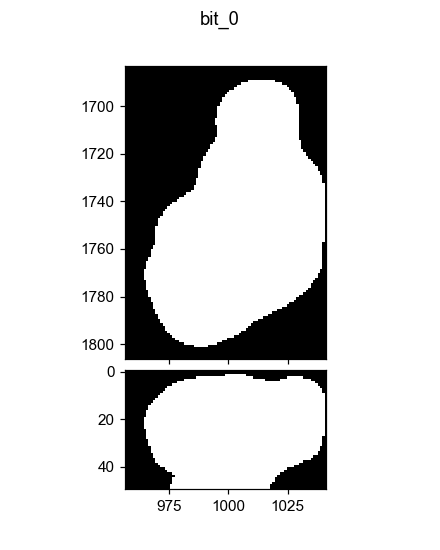

In [131]:
## visualize
bit_id = 0
spots = combo_raw_spot_list[bit_id]
coord_dict = {'coords':[np.flipud(_zxy[1:4]) for _zxy in spots],
              'class_ids':list(np.zeros(len(spots),dtype=np.int32)),
             }

visual_tools.imshow_mark_3d_v2([combo_ims[bit_id], aire_mask], 
                               given_dic=coord_dict,image_names=[f'bit_{bit_id}'],
                               save_file=None,
                               
                               )


In [100]:
sel_zxys[620]

array([  21.,   53., 1454.,  858.])

In [83]:
sel_zxys = []
for _zxy in seeds:
    if aire_mask[tuple(np.round(_zxy[:3]).astype(np.int32))] > 0:
        sel_zxys.append(_zxy)

In [77]:
tuple(np.round(_zxy).astype(np.int32))

(39, 1592, 266)

<IPython.core.display.Javascript object>


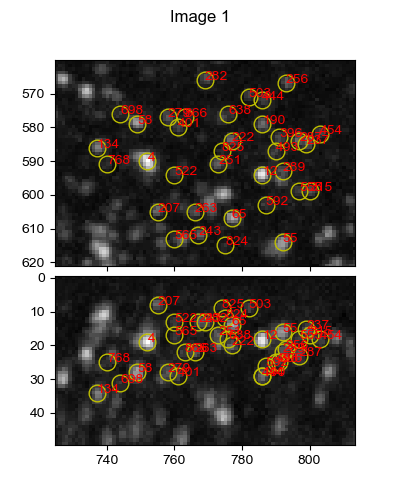

In [102]:
## visualize
coord_dict = {'coords':[np.flipud(_zxy[:3]) for _zxy in sel_zxys],
              'class_ids':list(np.zeros(len(sel_zxys),dtype=np.int32)),
             }

visual_tools.imshow_mark_3d_v2([image, aire_im, aire_mask], 
                               given_dic=coord_dict,
                               save_file=None,
                               )


<IPython.core.display.Javascript object>


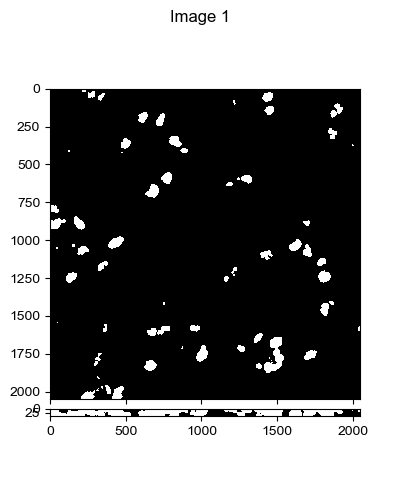

In [58]:
visual_tools.imshow_mark_3d_v2([aire_mask, aire_im, aire_adapteq_im, ])

In [44]:
from scipy import ndimage, stats
from skimage import morphology

_min_label_size = 200
_label = morphology.remove_small_objects(aire_mask, _min_label_size).astype(np.uint16)

_open_objects = morphology.opening(_label, morphology.ball(2))
_close_objects = morphology.closing(_open_objects, morphology.ball(3))
_label, _num = ndimage.label(_close_objects)


<IPython.core.display.Javascript object>


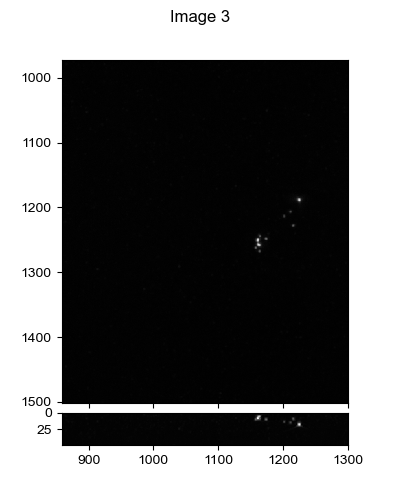

In [46]:
visual_tools.imshow_mark_3d_v2([_label, aire_mask, aire_im])

In [52]:
fov._load_from_file('combo')

+ loading combo from file: D:\Pu_Temp\20210729-Thymus_CTP10-Aire_DNA\Conv_zscan_06.hdf5
++ finish loading combo in 0.033s. 


In [53]:
fov.combo_drifts

array([[-2.0000000e-02,  0.0000000e+00,  0.0000000e+00],
       [-2.0000000e-02,  0.0000000e+00,  0.0000000e+00],
       [-5.3333335e-02,  1.0120000e+01,  2.0139999e+01],
       [-5.3333335e-02,  1.0120000e+01,  2.0139999e+01],
       [-6.6666670e-02,  1.0720000e+01,  1.2156667e+01],
       [-6.6666670e-02,  1.0720000e+01,  1.2156667e+01],
       [-8.6666666e-02,  1.2846666e+01,  6.5100002e+00],
       [-8.6666666e-02,  1.2846666e+01,  6.5100002e+00],
       [-7.3333330e-02,  1.2400000e+01,  7.4400001e+00],
       [-7.3333330e-02,  1.2400000e+01,  7.4400001e+00],
       [-5.3333335e-02,  1.2526667e+01,  1.6313334e+01],
       [-5.3333335e-02,  1.2526667e+01,  1.6313334e+01],
       [-6.6666670e-02,  1.1766666e+01,  1.4560000e+01],
       [-6.6666670e-02,  1.1766666e+01,  1.4560000e+01],
       [-5.3333335e-02,  1.3003333e+01,  9.5533333e+00],
       [-5.3333335e-02,  1.3003333e+01,  9.5533333e+00],
       [-5.3333335e-02,  1.3960000e+01,  4.1066666e+00],
       [-5.3333335e-02,  1.3960

<IPython.core.display.Javascript object>


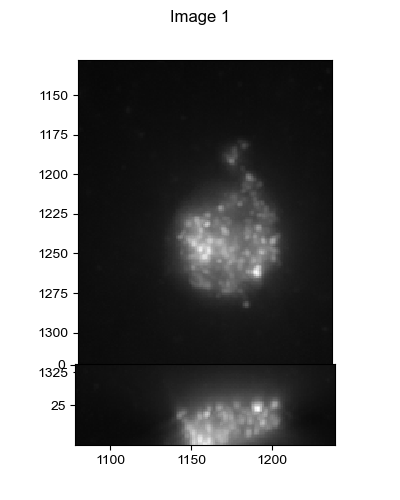

In [71]:
%matplotlib notebook
visual_tools.imshow_mark_3d_v2(list(protein_ims)+[fov.dapi_im])

In [25]:
class Mask(np.ndarray):
    
    def __init__(self, ):
        super().__init__()
    

In [106]:
combo_ims[1]

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ..., 380,   0,   0],
        [  0, 311, 278, ..., 240, 124,   0],
        ...,
        [  0,   0, 305, ..., 192, 478,   0],
        [  0,   0, 672, ..., 194, 411,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0, 297,  58, ..., 173,  45,   0],
        [  0,  47, 131, ..., 186, 111,   0],
        ...,
        [  0,  89, 179, ..., 437, 210,   0],
        [  0, 386, 394, ..., 178, 252,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   6, 162, ..., 258, 169,  15],
        [  0,   0, 547, ..., 387, 390,   0],
        ...,
        [  0, 283, 488, ..., 827, 311,   0],
        [  0, 243, 141, ..., 383, 578,   0],
        [  0,   0, 175, ...,   0,   0,   0]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,  51, ..., 147,  72,   0],
        [  0, 128,  59, ..., 296, 312,  17

In [31]:
from scipy import ndimage, stats
from skimage import morphology

In [51]:
from skimage import exposure
# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(aire_im, clip_limit=0.03)

In [52]:
img_adapteq.shape

(50, 2048, 2048)

In [74]:
def gaussian_high_pass_filter(image, sigma=5, truncate=2):
    lowpass = ndimage.gaussian_filter(image, sigma, mode='nearest', truncate=truncate)
    gauss_highpass = image - lowpass
    gauss_highpass[lowpass > image] = 0
    return gauss_highpass

In [ ]:
def translate_mask_by_drift(mask, drift,keep_edges=True):
    pass

_drift = fov.combo_drifts[2].copy()
_mask = aire_mask.copy()


In [126]:
_rough_drift = np.round(_drift).astype(np.int32)
_image_size = np.array(np.shape(_mask), dtype=np.int32)
_old_boundaries = np.array([np.zeros(len(_image_size)), _image_size])
_new_boundaries = _old_boundaries - _rough_drift
_new_boundaries[0,_new_boundaries[0]<0] = 0
_new_boundaries[1,_new_boundaries[1]>_image_size] = _image_size[_new_boundaries[1]>_image_size]

In [133]:
_crop = tuple([slice(_bd[0],_bd[1]) for _bd in np.transpose(_new_boundaries)])

In [135]:
_mask[_crop] 

TypeError: slice indices must be integers or None or have an __index__ method

In [128]:
_rough_shifted_mask = np.zeros(_image_size)
_rough_shifted_mask[]

array([[   0.,    0.,    0.],
       [  50., 2038., 2028.]])

In [122]:
%%timeit
_shifted_mask = ndimage.shift(_mask, -_drift, mode='constant', cval=0)

1 loop, best of 5: 1min 12s per loop


<IPython.core.display.Javascript object>


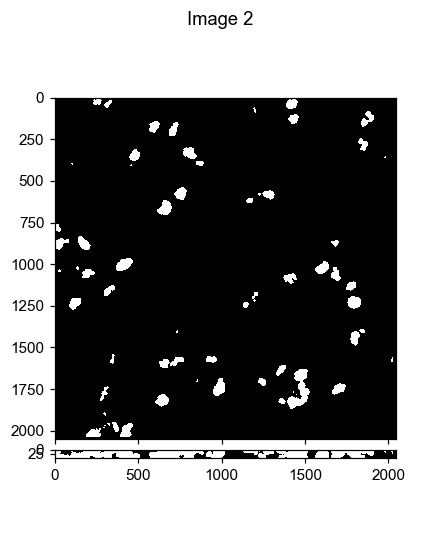

In [120]:
visual_tools.imshow_mark_3d_v2([_mask, _shifted_mask])

<IPython.core.display.Javascript object>


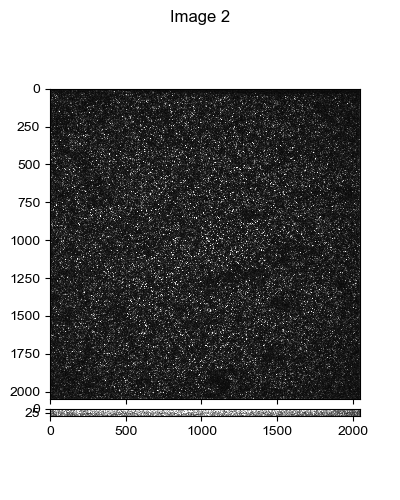

In [109]:
visual_tools.imshow_mark_3d_v2(combo_ims[::2][:3])

In [55]:
def high_pass_filter_individual_z(image, sigma= 5, truncate=2):
    lowpass = np.array([ndimage.gaussian_filter(image[z], sigma, mode='nearest', truncate=truncate)
                       for z in range(image.shape[0])])
    gauss_highpass = image - lowpass
    gauss_highpass[lowpass > image] = 0
    return gauss_highpass

In [56]:
hp_im = high_pass_filter_individual_z(protein_ims[0])

In [60]:
scale_hp_im = hp_im / np.max(hp_im)

In [78]:
hp_combo_im = gaussian_high_pass_filter(combo_ims[1])

<IPython.core.display.Javascript object>


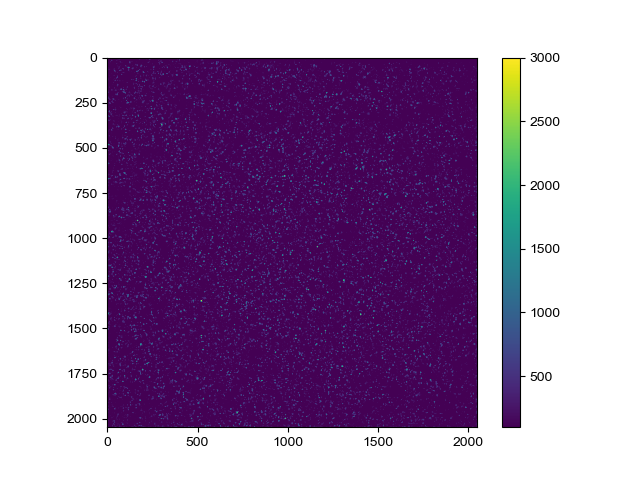

In [76]:
plt.figure()
plt.imshow(hp_combo_im[30], vmin=100, vmax=3000)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


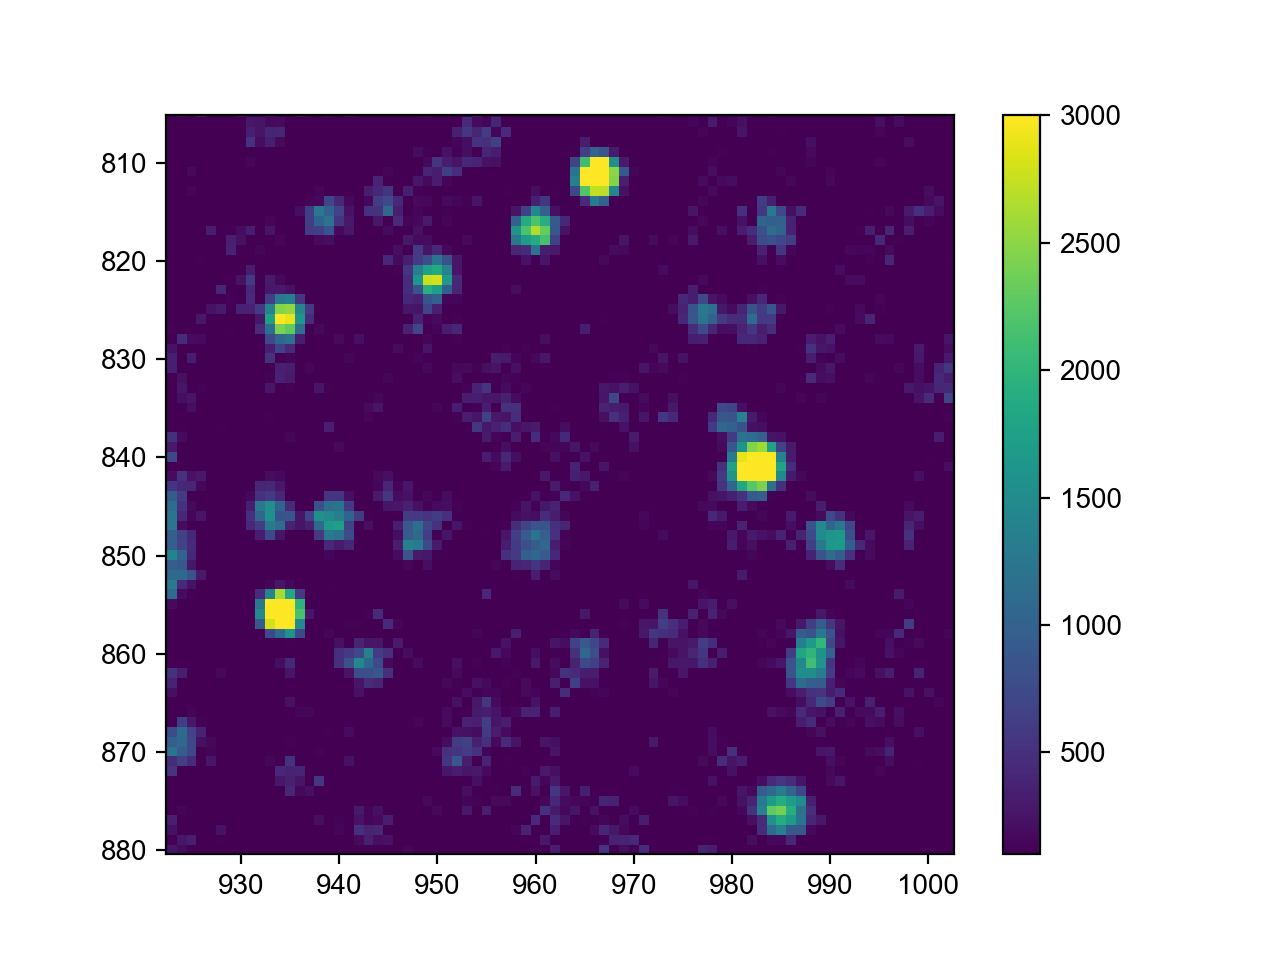

In [70]:
plt.figure()
plt.imshow(hp_combo_im[30], vmin=100, vmax=3000)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


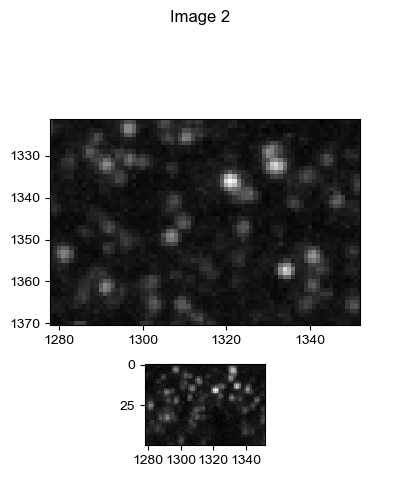

In [77]:
visual_tools.imshow_mark_3d_v2([combo_ims[0], hp_combo_im])

In [61]:
adpt_hp_im = exposure.equalize_adapthist(scale_hp_im, clip_limit=0.05)

<IPython.core.display.Javascript object>


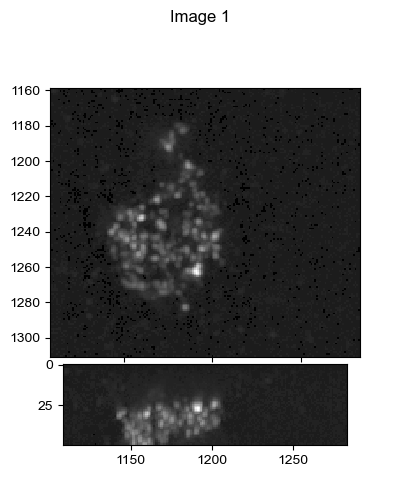

In [72]:
visual_tools.imshow_mark_3d_v2([adpt_hp_im, hp_im, protein_ims[0]])

<IPython.core.display.Javascript object>


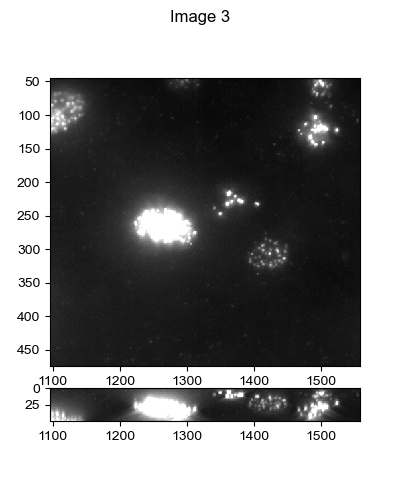

In [53]:
visual_tools.imshow_mark_3d_v2([_label, mask, protein_ims[0], img_adapteq])

In [37]:
mask.shape

(50, 2048, 2048)

In [8]:

snr_th = 1.5
_im = protein_ims[0]
_binary_im = _im >= io_tools.load.find_image_background(_im) * snr_th


In [10]:
# dilation and erosion
morphology_size = 2
_bim = ndimage.binary_dilation(_binary_im, morphology.ball(morphology_size))
_bim = ndimage.binary_erosion(_bim, morphology.ball(morphology_size))
_bim = ndimage.binary_fill_holes(_bim, structure=morphology.ball(morphology_size))

In [11]:
## 4. find object
_min_label_size = 150
_label = morphology.remove_small_objects(_bim, _min_label_size).astype(np.uint16)
_open_objects = morphology.opening(_label, morphology.ball(1))
_close_objects = morphology.closing(_open_objects, morphology.ball(2))
_label, _num = ndimage.label(_close_objects)
_label[_label==0] = -1

In [12]:
segment_label = _label.copy()

<IPython.core.display.Javascript object>


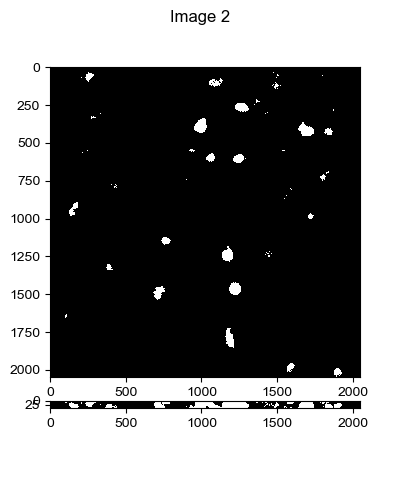

In [13]:
visual_tools.imshow_mark_3d_v2([_im, _binary_im, _label])

In [21]:
intensity_th = 500
vis_combo_inds = [0,1,2,3,4]
vis_combo_ims, vis_combo_ids, vis_combo_spot_list, vis_combo_raw_spot_list = [], [], [], []

with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    
    for _ind in vis_combo_inds:
        vis_combo_ims.append(_grp['ims'][_ind])
        vis_combo_ids.append(_grp['ids'][_ind])
        #_picked_inds = picked_spot_inds_list[_ind]
        #_picked_inds = np.array(_picked_inds[np.isnan(_picked_inds)==False], dtype=np.int)
        #vis_spot_list.append(raw_spots_list[_ind][_picked_inds])
        vis_combo_raw_spot_list.append(_grp['raw_spots'][_ind][_grp['raw_spots'][_ind][:,0] > intensity_th])

E:\Users\puzheng\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


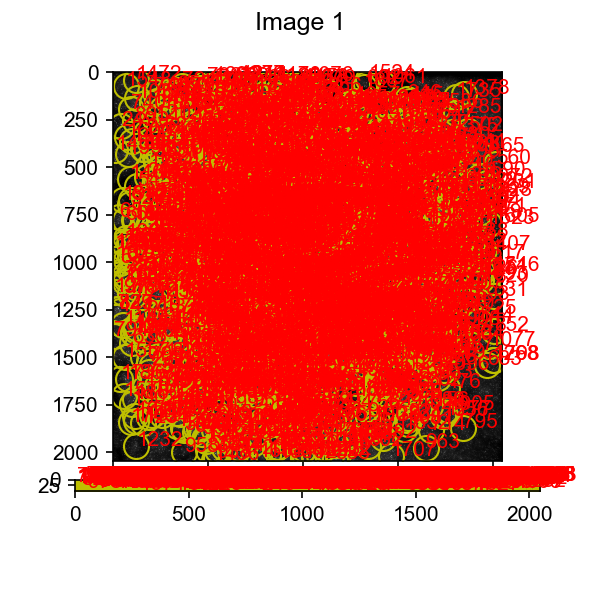

In [97]:
# visualize_all_chromosomes
%matplotlib notebook
%matplotlib notebook

## visualize
coord_dict = {'coords':[],
              'class_ids':[],
             }
for _i, _spots in enumerate(vis_combo_raw_spot_list):
    _sel_spots = _spots[_spots[:,0] > 200]
    coord_dict['coords'] += list(np.flipud(_spot[1:4]) for _spot in _sel_spots)
    coord_dict['class_ids'] += list(_i * np.ones(len(_sel_spots),dtype=np.int))

fig=plt.figure(figsize=(4,4), dpi=150)    
    
visual_tools.imshow_mark_3d_v2(list(vis_combo_ims)+[_im], 
                               fig=fig,
                               given_dic=coord_dict,
                               save_file=None,
                               )

In [14]:
def generate_crops_from_segmentation(segmentation_label, extend_dim=10):
    
    _crops = []

    for _l in range(int(np.max(segmentation_label))):
        #
        _binary_label = segmentation_label == _l + 1
        #
        _crop = []
        for _idim, _dim in enumerate(np.shape(segmentation_label)):
            _has_label = np.where(np.max(_binary_label, 
                                  axis=tuple([_i for _i in np.arange(len(np.shape(segmentation_label))) 
                                              if _i != _idim]))
                                 )[0]
            _llim, _rlim = np.min(_has_label), np.max(_has_label)+1
            _llim = max(0, _llim - extend_dim)
            _rlim = min(_dim, _rlim + extend_dim)
            _crop.append([_llim, _rlim])
        
        _crops.append(np.array(_crop, dtype=np.int32))
            
    return _crops
    

In [41]:
seg_crops = generate_crops_from_segmentation(segment_label, extend_dim=50)

In [42]:
def crop_warp_image(im:np.ndarray, 
                    crop_list:list, 
                    drift=None, 
                    chromatic_source=None, 
                    ):
    """Function to crop and warp images"""
    
    from scipy.ndimage.interpolation import map_coordinates
    for _icrop, crop in enumerate(crop_list):
        if _icrop != sel_crop:
            continue
        # generate coordinates
        _crop = np.array(crop, dtype=np.int32)
        _crop_sizes = _crop[:,1] - _crop[:,0]
        _pixel_coords = np.indices(_crop_sizes).reshape(len(_crop_sizes), -1) + _crop[:,0][:, np.newaxis]
        
        # add drift
        if drift is not None:
            _pixel_coords = _pixel_coords - drift[:len(_crop_sizes),np.newaxis]
        # add chromatic
        if chromatic_source is not None:
            # generate chromatic translation function
            _chromatic_func = correction_tools.chromatic.generate_chromatic_function(chromatic_source)
            # 
            _pixel_coords = _pixel_coords - (_chromatic_func(_pixel_coords.transpose()).transpose() - _pixel_coords)
            print(_crop)
            print(_pixel_coords)
        _cim = map_coordinates(im, _pixel_coords,
                       mode='nearest', cval=np.min(im))
        _cim = _cim.reshape(_crop_sizes)
            
            
            
        break
       
    return _cim

In [28]:
cim = crop_warp_image(combo_ims[0], seg_crops, chromatic_source=fov.correction_profiles['chromatic_constants']['750'])



[[   0   50]
 [ 566  648]
 [1199 1294]]
[[-8.05722909e-01 -8.05449261e-01 -8.05175613e-01 ...  4.88100986e+01
   4.88103722e+01  4.88106459e+01]
 [ 5.66845077e+02  5.66845056e+02  5.66845034e+02 ...  6.47642015e+02
   6.47641993e+02  6.47641971e+02]
 [ 1.19850028e+03  1.19949846e+03  1.20049664e+03 ...  1.29040445e+03
   1.29140262e+03  1.29240080e+03]]


In [17]:
with h5py.File(fov.save_filename, "r", libver='latest') as _f:
    _grp = _f['combo']
    combo_ims = _grp['ims'][:]
    combo_ids = _grp['ids'][:]
    combo_channels = _grp['channels'][:]
    combo_drifts = _grp['drifts'][:]

In [19]:
sel_crop = 1

In [43]:
cropped_ims = []
for _i, (_im, _ch, _dft) in enumerate(zip(combo_ims, combo_channels, combo_drifts)):
    print(_i)
    cim = crop_warp_image(_im, seg_crops, drift=_dft,
                          chromatic_source=fov.correction_profiles['chromatic_constants'][_ch.decode()])
    cropped_ims.append(cim)

0
[[   0   50]
 [ 526  688]
 [1159 1334]]
[[-8.25154312e-01 -8.24880664e-01 -8.24607016e-01 ...  4.88295300e+01
   4.88298036e+01  4.88300773e+01]
 [ 5.26918793e+02  5.26918771e+02  5.26918749e+02 ...  6.87568299e+02
   6.87568278e+02  6.87568256e+02]
 [ 1.15857316e+03  1.15957134e+03  1.16056951e+03 ...  1.33033157e+03
   1.33132975e+03  1.33232792e+03]]
1
2
[[   0   50]
 [ 526  688]
 [1159 1334]]
[[-7.72334045e-01 -7.72060397e-01 -7.71786749e-01 ...  4.88823502e+01
   4.88826239e+01  4.88828975e+01]
 [ 5.17219689e+02  5.17219667e+02  5.17219645e+02 ...  6.77869195e+02
   6.77869173e+02  6.77869151e+02]
 [ 1.16194373e+03  1.16294190e+03  1.16394008e+03 ...  1.33370214e+03
   1.33470031e+03  1.33569849e+03]]
3
4
[[   0   50]
 [ 526  688]
 [1159 1334]]
[[-7.56950740e-01 -7.56677092e-01 -7.56403444e-01 ...  4.88977335e+01
   4.88980072e+01  4.88982808e+01]
 [ 5.15808738e+02  5.15808716e+02  5.15808694e+02 ...  6.76458244e+02
   6.76458222e+02  6.76458200e+02]
 [ 1.16994579e+03  1.1709439

45
46
[[   0   50]
 [ 526  688]
 [1159 1334]]
[[-7.96495674e-01 -7.96222026e-01 -7.95948378e-01 ...  4.88581886e+01
   4.88584623e+01  4.88587359e+01]
 [ 5.09336804e+02  5.09336782e+02  5.09336761e+02 ...  6.69986311e+02
   6.69986289e+02  6.69986267e+02]
 [ 1.19063124e+03  1.19162942e+03  1.19262759e+03 ...  1.36238965e+03
   1.36338783e+03  1.36438600e+03]]
47
48
[[   0   50]
 [ 526  688]
 [1159 1334]]
[[-8.00377067e-01 -8.00103419e-01 -7.99829771e-01 ...  4.88543072e+01
   4.88545809e+01  4.88548545e+01]
 [ 5.24530191e+02  5.24530169e+02  5.24530147e+02 ...  6.85179697e+02
   6.85179675e+02  6.85179653e+02]
 [ 1.14009364e+03  1.14109181e+03  1.14208999e+03 ...  1.31185204e+03
   1.31285022e+03  1.31384840e+03]]
49


In [130]:
cim = crop_warp_image(vis_combo_ims[3], seg_crops, chromatic_source=fov.correction_profiles['chromatic_constants']['750'])

[[   0   50]
 [ 208  307]
 [1415 1502]]
(3, 430650)


In [22]:
aire_cim = protein_ims[0][tuple([slice(_c[0], _c[1]) for _c in seg_crops[sel_crop]])]

<IPython.core.display.Javascript object>


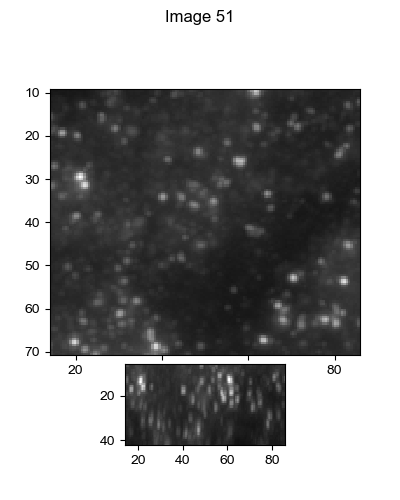

In [44]:
visual_tools.imshow_mark_3d_v2([aire_cim] + cropped_ims)

In [141]:
fov._load_from_file('combo')

+ loading combo from file: D:\Pu_Temp\20210729-Thymus_CTP10-Aire_DNA\Conv_zscan_03.hdf5
++ finish loading combo in 0.006s. 


In [30]:
bead_im = fov._load_bead_image(_bead_id=1)

- correct the whole fov for image: \\10.245.74.40\Turing3\Pu\Aire\20210729-Thymus_CTP10-Aire_DNA\H1C2\Conv_zscan_05.dax
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- loading image from file:\\10.245.74.40\Turing3\Pu\Aire\20210729-Thymus_CTP10-Aire_DNA\H1C2\Conv_zscan_05.dax  in 5.234s
-- removing hot pixels for channels:['488'] in 4.735s
-- illumination correction for channels: 488, in 1.546s
-- warp image with drift:[0. 0. 0.] in 0.000s
-- finish correction in 11.908s


<IPython.core.display.Javascript object>


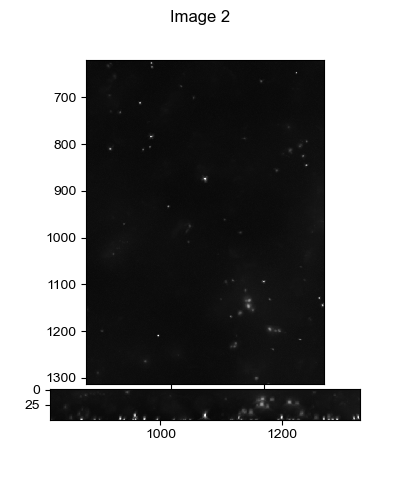

In [31]:
visual_tools.imshow_mark_3d_v2([fov.combo_ref_im, bead_im])

In [37]:
drift_crops = correction_tools.alignment.generate_drift_crops(fov.shared_parameters['single_im_size'])

In [38]:
ref_cim = crop_warp_image(fov.combo_ref_im, drift_crops,)

In [39]:
tar_cim = crop_warp_image(bead_im, drift_crops, drift=combo_drifts[2])

<IPython.core.display.Javascript object>


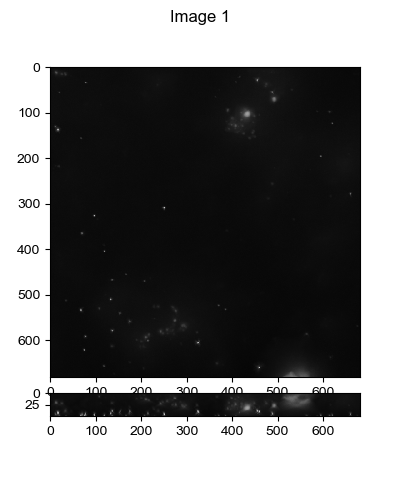

In [40]:
visual_tools.imshow_mark_3d_v2([ref_cim, tar_cim])

In [163]:
combo_drifts

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [ -0.09      ,   8.58      ,   1.45      ],
       [ -0.09      ,   8.58      ,   1.45      ],
       [ -0.11      ,  10.97      ,  -6.3       ],
       [ -0.11      ,  10.97      ,  -6.3       ],
       [ -0.14      ,  12.666667  , -14.19      ],
       [ -0.14      ,  12.666667  , -14.19      ],
       [ -0.10333333,  13.426666  , -15.216666  ],
       [ -0.10333333,  13.426666  , -15.216666  ],
       [ -0.09      ,  13.33      , -11.55      ],
       [ -0.09      ,  13.33      , -11.55      ],
       [ 21.8875    ,   9.5525    ,  -6.0325    ],
       [ 21.8875    ,   9.5525    ,  -6.0325    ],
       [ -0.09666666,  13.38      ,  -7.55      ],
       [ -0.09666666,  13.38      ,  -7.55      ],
       [ -0.12      ,  14.026667  , -19.816668  ],
       [ -0.12      ,  14.026667  , -19.816668  ],
       [ -0.09      ,  14.486667  , -22.036667  ],
       [ -0.09      ,  14.48666